<a target="_blank" href="https://colab.research.google.com/github/Shmoo137/ML-Tutorials/blob/main/TetrisCNN-Interpretable_NN_for_phases_of_matter.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# TetrisCNN - an interpretable neural network for spin data
### By Kacper Cybiński, Anna Dawid, James Enouen, and Björn van Zwol

Today we're going to implement TetrisCNN, introduced by K. Cybiński, J. Enouen, A. Georges, & A. Dawid in [Speak so a physicist can understand you! TetrisCNN for detecting phase transitions and order parameters, NeurIPS'24 ML4PS workshop](https://arxiv.org/abs/2411.02237).

We will use the same datasets that you have already worked with. The classical 2D Ising model and the more complex Ising Lattice Gauge Theory (ILGT) model. We will load data for you so you can jump right to the architecture and numerical experiments.

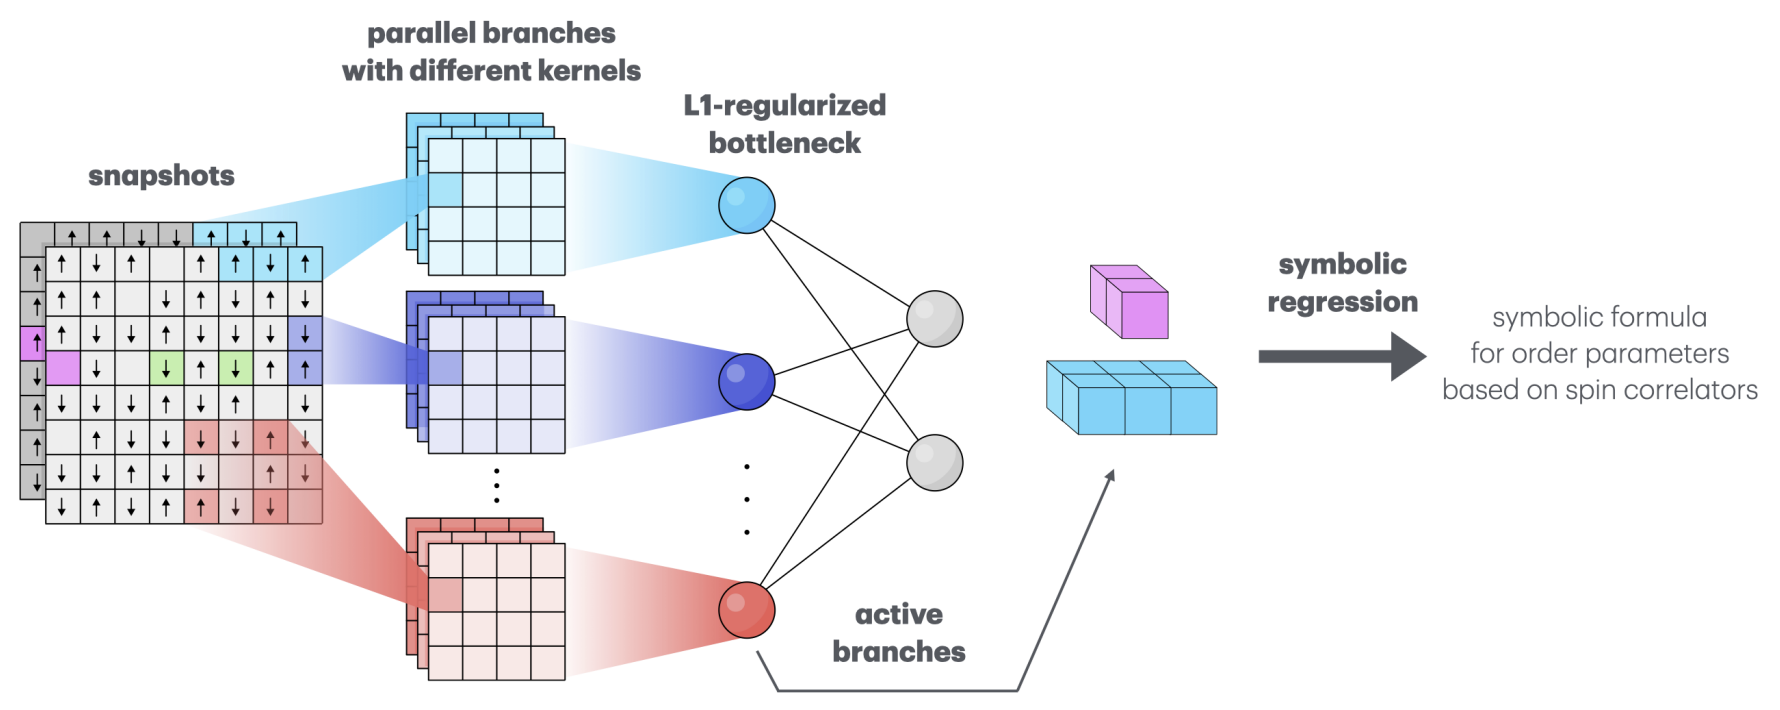

In [ ]:
import numpy as np

# We will design the network and train it in PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# For convenient data loading
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# To plot progress bars
from tqdm.notebook import trange, tqdm
# To calculate how long the training takes
from datetime import datetime

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## 1. Loading datasets
Both datasets are on the QMAI GitHub repo, so we will start by cloning it. We will make two classes: `Ising_Dataset` and `ILGT_Dataset`, which load spin configurations and the corresponding labels.
- In the case of the Ising model, spin configurations were generated for various temperatures $T$. In the previous excercise, you were told that we know that in the thermodynamical limit, the critical temperature, where the phase transition occurs, is $T_c = 2.2692$ K. To simplify the task today, we will only focus on analyzing what the network learned and ignore the part where network should tell us where the transition occurs. Therefore, in the `Ising_Dataset` class, you'll see that we label spin configurations as coming from class 0 if their $T < T_c$, and class 1 if $T \geq T_c$.
- In the case of the ILGT, the labeling is done for us. Again, the focus will be to understand what the network learns, so the datasets are simpler than they would be in a regular case.

**For interested readers:** To see an example of unsupervised classification of phases, accompanied by the detection of the relevant correlators, see the paper! :)

In [ ]:
!git clone https://gitlab.com/QMAI/mlqe2022_public.git

fatal: destination path 'mlqe2022_public' already exists and is not an empty directory.


In [ ]:
# The directory in git "MLQE2022_public" that has the data:
directory = "mlqe2022_public/day_1/Ising"

In [ ]:
class Ising_Dataset(Dataset):
    def __init__(self, train):
        N = 30
        if (train):
            data = np.load("{1}/ising_training_configs_{0}x{0}.npy".format(N, directory))
            labels = np.load("{1}/ising_training_labels_{0}x{0}.npy".format(N, directory)) # Temperature
        else:
            data = np.load("{1}/ising_test_configs_{0}x{0}.npy".format(N, directory))
            labels = np.load("{1}/ising_test_labels_{0}x{0}.npy".format(N, directory)) # Temperature

        self.data = torch.tensor(data).float().reshape(-1, 1, N, N)  # (N, H, W, C) -> (N, C, H, W) (pytorch format)

        # If T < Tc, put 0, if T >= Tc put 1
        Tc = 2.2692
        labels[labels < Tc] = 0
        labels[labels >= Tc] = 1
        labels = torch.tensor(labels).long()
        no_classes = len(torch.unique(labels))

        self.labels = F.one_hot(labels, num_classes=no_classes).float()  # One-hot encode

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class ILGT_Dataset(Dataset):
    def __init__(self, train):
        if (train):
            data = np.load("{0}/ilgt_training_configs.npy".format(directory))
            labels = np.load("{0}/ilgt_training_labels.npy".format(directory))
        else:
            data = np.load("{0}/ilgt_test_configs.npy".format(directory))
            labels = np.load("{0}/ilgt_test_labels.npy".format(directory))

        self.data = torch.tensor(data).float().permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W) (pytorch format)

        labels = torch.tensor(labels).long()
        no_classes = len(torch.unique(labels))

        self.labels = F.one_hot(labels, num_classes=no_classes).float()  # One-hot encode

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
# You will later define the train and validation dataset and dataloader in the following way:
train_dataset = Ising_Dataset(train=True)
val_dataset = Ising_Dataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False) # We have 1000 examples in the test set

## 2. TetrisCNN design

We arrive at the most demanding part of the code today. It is written already for you, but you will need a certain level of understanding of what is going on to realize your tasks at the end of the notebook.

You will learn two things in this part of the tutorial:
- How to design a custom neural network.
- How is TetrisCNN constructed from basic PyTorch elements.

**A digression** that may encourage you to look closer at this part: The most effective approach for using deep learning in scientific problems is, in my opinion, building custom neural networks, tailored to your data and task (which may be very different from the ones used in computer science and which standard neural networks are built and opitimized for). After learning how standard models work, the next step to become a successful "ML for science" researcher is understand the advantages and disadvantages of each neural network building block and starts playing and combining them in the ways needed by your task.

### 2.1 A regular CNN that will be used as a branch in TetrisCNN
We need here a normal CNN, whose hyperparameters (especially shapes of kernels) can be defined externally. This is the reason for the long hyperparameter list of `__init__` function. We will define here two-layer CNN. The first layer has a kernel shape defined externally, the second layer has a pre-defined 1x1 kernel, so no additional spatial correlations can be picked up.

In [ ]:
class ConvBranch_twoLayer(nn.Module):
    def __init__(
        self,
        in_channels, # It will depend on the dataset. Ising has one channel, ILGT - two channels, but we will read it out automatically from data
        kernel_shape, # The most important part - we will play with these shapes and each CNN instance in each branch will have another kernel shape
        number_of_filters, # How many copies of the same kernel shape the network has in the second CNN layer
        hidden_size, # How many copies of the same kernel shape the network has in the first CNN layer
        dilation=1,
        padding_size=0,
        padding_mode=None,
        mask=None,
        init="kaiming",
    ):
        super().__init__()

        self.input_dim = in_channels
        self.kernel_shape = kernel_shape
        self.hidden_size = hidden_size
        self.number_of_filters = number_of_filters  # this is only used in the second layer

        if padding_mode is None:
            padding_mode = "zeros"
            padding_size = 0

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.hidden_size,
            kernel_size=self.kernel_shape,
            stride=1,
            padding=padding_size,
            padding_mode=padding_mode,
            dilation=dilation,
        )
        self.conv2 = nn.Conv2d(
            in_channels=self.hidden_size,
            out_channels=self.number_of_filters,
            kernel_size=1,
            stride=1,
            padding=0,
        )

        # Ignore the mask in this excercise (but it allows for more complicated kernel shapes)
        if mask is not None:
            print("Using mask: ", mask)
            assert tuple(mask.squeeze().shape) == kernel_shape, "Mask does not match kernel shape."
        else:
            print("No mask.")
        self.register_buffer("mask", mask)

    def forward(self, x):
        if self.mask is not None:
            self.conv1.weight.data *= self.mask  # Enforce mask constraint

        # print(f"conv 1 weight: {self.conv1.weight.shape}")
        # compute features (kxk convolution, then ReLU, then 1x1 convolution)
        f = self.conv1(x) # the CNN with externally defined kernel shape
        f = F.relu(f) # our non-linearity allowing for "interactions" between input elements
        f = self.conv2(f) # only 1x1 kernel! No longer-range spatial correlations can be picked up, used only to increase expressivity

        # average (global pool) over the entire image
        f = torch.mean(f, dim=(2, 3)) # we know that the correlators are something averaged over the system size

        return f

### 2.2 The first half of the TetrisCNN - a multibranch neural network

We need here a multibranch network where each branch is an instance of `ConvBranch_twoLayer` defined above, with different kernel shapes defined again externally.

In [ ]:
class ShapeAdaptiveConvNet(nn.Module):
    def __init__(
        self, in_channels, kernels, padding_size=0, padding_mode=None, hidden_size=32, init="kaiming",
    ):
        super().__init__()

        self.in_channels = in_channels
        self.kernels = kernels
        self.branches = nn.ModuleList()
        self.branch_model = ConvBranch_twoLayer

        # Here we iteratively create branches whose number depends on the length of the list of kernel shapes that we provide externally
        for k in range(len(self.kernels)):
            self.branches.append(
                self.branch_model(
                    in_channels=in_channels,
                    kernel_shape=kernels[k][0],
                    number_of_filters=kernels[k][1],
                    hidden_size=hidden_size,
                    dilation=(kernels[k][2], 1), # ! here dilation works only in the X direction, we need to fix it :P not relevant fot this excercise
                    padding_size=padding_size,
                    padding_mode=padding_mode,
                    mask=torch.tensor(np.array(kernels[k][3]),
                                      dtype=torch.float32)
                                      if kernels[k][3] is not None else None,
                    init=init,
                )
            )

    def forward(self, x):
        all_filters = []
        for k in range( len(self.kernels) ):
            h = self.branches[k](x)
            all_filters.append(h)

        return torch.cat(all_filters, dim=1)

### 2.3 The second half of TetrisCNN - the task network
Finally, the easiest part. A normal feed-forward network that will solve the task depending on the bottleneck values created by the `ShapeAdaptiveConvNet`. We call this network `SmallModel`.

In [ ]:
class SmallModel(nn.Module):
    def __init__(self, sizes):
        super(SmallModel, self).__init__()

        self.sizes = sizes
        self.length = len(self.sizes) - 1
        self.activation = F.relu

        self.hiddens = nn.ModuleList()
        for k in range(self.length):
            self.hiddens.append(nn.Linear(self.sizes[k], self.sizes[k + 1]))

    def forward(self, x):
        h = x
        for k in range(self.length):
            h = self.hiddens[k](h)
            if k != self.length - 1:
                h = self.activation(h)
        return h

    def collectParameters(self):
        all_param_list = []
        for k in range(self.length):
            for x in self.hiddens[k].parameters():
                all_param_list.append(x.view(-1))
        return torch.cat(all_param_list)

### 2.4 $L_1$ regularization on the bottleneck
To interpret the network, we rely on the sparsity of the bottleneck (meaning the network zeros out unneeded branches). The signal to zero out branches comes exactly from the $L_1$ regularization put on top of the bottleneck activations. This regularization means that the network pays a linear cost for every bottleneck activation. It will be added in the end to the full loss function that is minimized during the training.

The user sets the strength of $L_1$ regularization that is **penalties** for using every branch. We will penalize usage of larger kernels, therefore promote using the simplest one that can solve the task.

In [ ]:
def l1_regularization(z, penalties):
    """"
    Returns $\sum_{k=1}^K |z_k| \lambda_k$, where $z_k$ is the $k-$th bottleneck activation,
    and $\lambda_k$ is the corresponding penalty for this branch. l1 regularization encourages
    sparsity in the bottleneck, and penalties encourage simplicity.
    """
    assert z.shape[1] == len(penalties), "Number of penalties must match the number of branches."
    branches = torch.abs(z)
    branches *= penalties
    return torch.sum( branches , dim=1 ) # sum over the branches

### 2.5 Additional useful functions for training and visualization

In [ ]:
class EarlyStopper:
    """
    Standard early stopping class.
    """
    def __init__(self, patience=1, min_delta=0, verbose=True, relative=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_obj = float('inf')
        self.verbose = verbose
        self.relative = relative

    def early_stop(self, validation_obj):
        if np.isnan(validation_obj):
            print("Validation objective is NaN. Stopping early.")
            return True
        difference = validation_obj - self.min_validation_obj
        if self.relative:
            difference /= self.min_validation_obj
        if validation_obj < self.min_validation_obj:
            if self.verbose:
                print(f"Validation objective decreased ({self.min_validation_obj:.2e} --> {validation_obj:.2e}).")
            self.min_validation_obj = validation_obj
            self.counter = 0
        elif difference >= self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation objective increased ({self.min_validation_obj:.2e} --> {validation_obj:.2e}).")
                print(f"Early stopping counter: {self.counter} out of {self.patience}\n")
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def kernel_to_pattern(pattern_spec):
    """
    Convert a kernel specification to a LaTeX pattern representation.
    """
    dimensions, _, dilation, mask = pattern_spec
    width, height = dimensions

    # Calculate the effective width and height considering dilation
    expanded_width = width + (width - 1) * (dilation - 1)
    expanded_height = height + (height - 1) * (dilation - 1)

    if mask is None:
        mask = np.ones(dimensions)
    else:
        mask = np.array(mask)

    base_pattern = []
    for i in range(expanded_height):
        row = ""  # Initialize an empty string to build the row
        for j in range(expanded_width):
            if j % dilation != 0 or i % dilation != 0 or mask[j,i] != 1: # NB: j, i
                row += "\u25A1"  # filled square character
            else:
                row += "\u25A0"  # empty square character
        base_pattern.append(row)

    if height > 1:
        latex_pattern = "\\substack{" + " \\\\ ".join(base_pattern) + "}"
    else:
        latex_pattern = base_pattern[0]

    return rf"${latex_pattern}$"

In [ ]:
def plot_history(metrics, kernels, file_name):
    """"
    Plots losses and the bottleneck activations for each epoch.
    """

    metric1, metric2 = "train_loss", "train_l1"
    metric3, metric4 = "val_loss", "val_l1"
    metric5 = "val_acc"

    # Create z and z_std arrays
    z = np.array([ np.abs(np.mean(metrics[f'z_{i}'], axis=1)) for i in range(len(kernels)) ]) # mean over the batch

    fig = plt.figure(figsize=(6, 10))
    # subplot 1/3: all the losses, including the l1
    plt.subplot(4, 1, 1)
    plt.plot(metrics[metric1], label=metric1, color="red")
    plt.plot(metrics[metric2], label=metric2, color = "red",linestyle="--")
    plt.plot(metrics[metric3], label=metric3, color="blue")
    plt.plot(metrics[metric4], label=metric4, color="blue", linestyle="--")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Losses")

    # subplot 2/3: acc
    plt.subplot(4, 1, 2)
    plt.plot(metrics[metric5], label=metric5, color="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")

    # subplot 3/3: the bottleneck
    plt.subplot(4, 1, 3)
    for i in range(len(kernels)):  # bottleneck has shape (len(cf.kernels)). plot each branch separately
        plt.plot(z[i], label=kernel_to_pattern(kernels[i]))

    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())  # make legend same color as lines
    plt.xlabel("epoch")
    plt.ylabel("abs(z)")
    plt.title("Bottleneck activations")
    plt.yscale("log")

    plt.tight_layout()
    plt.show()
    plt.close()

## 3. TetrisCNN training on chosen dataset

### 3.1 We start by loading a dataset. Let's do the Ising model first!

In [ ]:
train_dataset = Ising_Dataset(train=True)
val_dataset = Ising_Dataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False) # We have 1000 examples in the test set

In [ ]:
"""
train_dataset = ILGT_Dataset(train=True)
val_dataset = ILGT_Dataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2000, shuffle=False) # We have 2000 examples in the test set
"""

'\ntrain_dataset = ILGT_Dataset(train=True)\nval_dataset = ILGT_Dataset(train=False)\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=2000, shuffle=False) # We have 2000 examples in the test set\n'

In [ ]:
# We can read out the quanitites needed for the TetrisCNN straight from our loaded dataset
data_dimensions = train_dataset.data.shape
no_channels = data_dimensions[1] # For Ising it's one but ILGT is encoded in two channels
no_classes = train_dataset.labels.shape[1]  # One-hot encoded

### 3.2 The best part: define various kernel shapes and their penalties that will be used in different TetrisCNN branches

In [ ]:
# syntax: [(kernel_shape, number_of_filters, dilation, mask),...]
kernels = [[(1, 1), 1, 1, None],
          [(1, 2), 1, 1, None],
          [(2, 1), 1, 1, None],
          [(2, 2), 1, 1, None],
          [(3, 3), 1, 1, None]]
# The penalties below mean that kernel 1x1 will get penalty of 10^(-5), kernel 1x2 - 10^(-4), ..., kernel 3x3 - 10^(-1).
# We therefore promote the usage of 1x1 over 1x2, etc.
penalties = torch.tensor(np.logspace(-5, -1, len(kernels))).float()
#penalties = torch.tensor(np.logspace(0.1, 1.0, len(kernels))).float()
hidden_size = 32

In [ ]:
# Model definition. We have two parts, the ShapeAdaptiveConvNet (the multi-branch guy)
# and the SmallModel (a basic fully-connected network), we need to define both of them.
# The SmallModel dimensions depend on the size of the bottlenech that the first network outputs (one number per branch)
net2_dims = [len(kernels), 32, 16, no_classes]
net1 = ShapeAdaptiveConvNet(in_channels=no_channels, kernels=kernels, hidden_size=hidden_size)
net2 = SmallModel(net2_dims)

No mask.
No mask.
No mask.
No mask.
No mask.


### 3.3 Training

In [ ]:
# Optimizer and training hyperparameters.
# You're free to play with them! We'll use an Early Stopper, so the training can stop before the number of epochs defined here.
epochs = 100
learning_rate = 1e-3
weight_decay = 1e-5
patience = 10
optimizer = optim.Adam( list(net1.parameters()) + list(net2.parameters()), # two networks with parameters to be optimized!
                        lr=learning_rate , weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

early_stopper = EarlyStopper(patience=patience, min_delta=0)

In [ ]:
# Let's gather data for plotting
metrics = {"train_loss": [], "train_l1": [], "val_loss": [], "val_l1": [], "val_acc": [],
            "corr": [], "out0": [], "out1": [], "labels" : []}
for i in range(len(kernels)):
  metrics[f"z_{i}"] = []
  metrics[f"w_{i}"] = [] # weights

In [ ]:
# TRAINING
start_time = datetime.now()
for epoch in tqdm(range(epochs)):
    net1.train()
    net2.train()

    for i, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()

        z = net1(x)
        out = net2(z)

        loss = criterion(out, y)
        l1 = torch.sum( l1_regularization(z, penalties) )  # sum over the batch
        loss += l1 # here we're adding the bottleneck penalties to the full loss

        loss.backward()
        optimizer.step()

    metrics["train_loss"].append(loss.item()/train_loader.batch_size)
    metrics["train_l1"].append(l1.item()/train_loader.batch_size)

    # VALIDATION
    net1.eval()
    net2.eval()
    loss, acc = 0, 0
    with torch.no_grad(): # this enables larger batch size for validation; less memory
        for i, (x, y) in enumerate(val_loader):

            z = net1(x)
            out = net2(z)

            acc += torch.mean(( torch.argmax(out.data, axis=1) == torch.argmax(y, axis=1) ).float()).item()
            loss += criterion(out, y).item()
            l1 = torch.sum( l1_regularization(z, penalties) ).item()  # sum over the batch
            loss += l1

        metrics["val_loss"].append(loss/val_loader.batch_size)
        metrics["val_l1"].append(l1/val_loader.batch_size)
        metrics["val_acc"].append(acc/len(val_loader))

        for i in range(len(kernels)):
            metrics[f"z_{i}"].append( z[:, i].cpu().numpy().tolist() )
            metrics[f"w_{i}"].append(  net1.branches[i].conv1.weight.cpu().numpy().tolist() )

        print(f"\nEPOCH {epoch+1}/{epochs}, TRAIN loss: {metrics['train_loss'][-1]:.2e}, l1: {metrics['train_l1'][-1]:.2e}, VAL loss: {metrics['val_loss'][-1]:.2e}, l1: {metrics['val_l1'][-1]:.2e}, VAL acc: {metrics['val_acc'][-1]:.2f}")

        if early_stopper.early_stop(metrics["val_loss"][-1]):
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

  0%|          | 0/100 [00:00<?, ?it/s]


EPOCH 1/100, TRAIN loss: 2.09e-02, l1: 2.33e-04, VAL loss: 1.51e-03, l1: 8.29e-04, VAL acc: 0.50
Validation objective decreased (inf --> 1.51e-03).

EPOCH 2/100, TRAIN loss: 2.12e-02, l1: 1.58e-04, VAL loss: 1.28e-03, l1: 6.33e-04, VAL acc: 0.74
Validation objective decreased (1.51e-03 --> 1.28e-03).

EPOCH 3/100, TRAIN loss: 2.08e-02, l1: 9.13e-05, VAL loss: 9.13e-04, l1: 3.72e-04, VAL acc: 0.88
Validation objective decreased (1.28e-03 --> 9.13e-04).

EPOCH 4/100, TRAIN loss: 6.46e-03, l1: 1.07e-04, VAL loss: 8.70e-04, l1: 4.53e-04, VAL acc: 0.92
Validation objective decreased (9.13e-04 --> 8.70e-04).

EPOCH 5/100, TRAIN loss: 1.19e-02, l1: 1.36e-04, VAL loss: 8.77e-04, l1: 5.56e-04, VAL acc: 0.94
Validation objective increased (8.70e-04 --> 8.77e-04).
Early stopping counter: 1 out of 10


EPOCH 6/100, TRAIN loss: 7.47e-03, l1: 1.22e-04, VAL loss: 6.55e-04, l1: 4.26e-04, VAL acc: 0.96
Validation objective decreased (8.70e-04 --> 6.55e-04).

EPOCH 7/100, TRAIN loss: 2.92e-03, l1: 1.29

In [ ]:
metrics["out0"] = out[:,0].cpu().numpy().tolist()
metrics["out1"] =  out[:,1].cpu().numpy().tolist()
metrics["labels"] = y.cpu().numpy().tolist()

metrics["params_net1"] = str(sum([np.prod(p.shape) for p in net1.parameters()])) # NOTE: I am not yet removing mask, and gcnn stuff
metrics["train_time"] = str(datetime.now() - start_time)

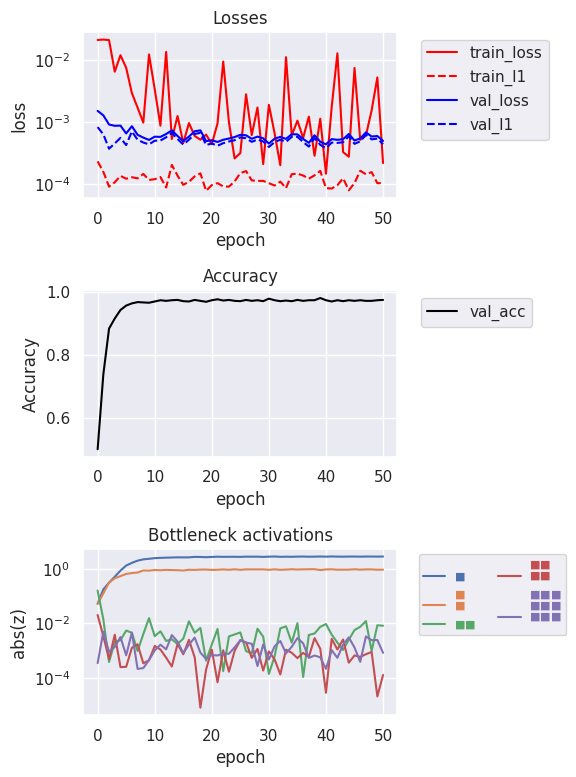

In [ ]:
plot_history(metrics, kernels, "history.png")

When you look at the curves above, you analyze two things:
- one, as for every network, you check how the training curve looks like, and whether the final accuracy is acceptable.
- two, only for TetrisCNN, you check what branches are used, what branches are killed, and this gives you an idea what correlators the network is using to solve the task. This it the interpretability feature of TetrisCNN.

The tasks for today are the following:
1. Stay for now with the Ising model. Check and answer the following:
- What branches does TetrisCNN use, when there's no penalty? Are these results repeatable between trainings or they change for every training? Is penalty necessary for interpretability? Why?
- What branches does TetrisCNN use, when we penalize strongly larger and more complex kernels? Is it repeatable between trainings?
- Change the critical temperature that determines labeling in the Ising dataset to something strange, like $T_c = 1$. The network no longer learns the phase transition here. Are the relevant correlators the same or not? Why do you think that is?

2. Find the relevant correlator for ILGT dataset. The code to load this dataset is commented out above (below loading the Ising model). What do you observe here? Hint: it may require both tweaking penalties and training hyperparameters.
